In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mplcyberpunk


plt.style.use('cyberpunk')

# Part-A

In [2]:
class Arm:
    def __init__(self, mean, variance=1):
        self.mean = mean
        self.variance = variance
    
    def reward(self):
        return np.random.normal(self.mean, self.variance)


class Bandits:
    def __init__(self, K: int, means: np.ndarray):
        self.arms = [Arm(i) for i in means]
    
    def reward(self, idx: int):
        return self.arms[idx].reward()


# Part-B

In [3]:
class e_greedy:
    """
    Can be used for greedy, epsilon-greedy, epsilon-greedy with decay
    """
    def __init__(self, bandits: Bandits, eps: float, eps_decay: float, optimism = 0):
        self.bandits = bandits
        self.eps = eps
        self.estimated_means = np.zeros_like(bandits.arms)
        self.visits = np.zeros_like(bandits.arms)
        self.K = bandits.arms.__len__()
        self.eps_decay = eps_decay
        self.estimated_means[:] = optimism
    
    def run(self, N: int, M: int=10):
        rewards = []
        regrets = []
        for i in range(M):
            for idx in range(self.K):
                reward = self.bandits.reward(idx)
                rewards.append(reward)
                self.visits[idx] += 1
                self.estimated_means[idx] += (reward-self.estimated_means[idx])/self.visits[idx]
                best_reward = self.bandits.reward(-1)
                regrets.append(best_reward-reward)

        for i in range(M*self.K, N):
            if np.random.random() < self.eps:
                idx = np.random.randint(0, self.K)
            else:
                idx = np.random.choice(np.flatnonzero(self.estimated_means== self.estimated_means.max()))
            reward = self.bandits.reward(idx)
            rewards.append(reward)
            self.visits[idx] += 1
            self.estimated_means[idx] += (reward-self.estimated_means[idx])/self.visits[idx]
            self.eps *= self.eps_decay
            best_reward = self.bandits.reward(-1)
            regrets.append(best_reward-reward)
        return np.array(rewards), np.array(regrets)


class UCB:
    def __init__(self, bandits: Bandits, optimism=0):
        self.bandits = bandits
        self.estimated_means = np.zeros_like(bandits.arms)
        self.visits = np.zeros_like(bandits.arms, dtype=float)
        self.K = bandits.arms.__len__()
        self.estimated_means[:] = optimism
    
    def run(self, N: int):
        rewards = []
        regrets = []
        for idx in range(self.K):
            reward = self.bandits.reward(idx)
            rewards.append(reward)
            self.visits[idx] += 1
            self.estimated_means[idx] += (reward-self.estimated_means[idx])/self.visits[idx]
            best_reward = self.bandits.reward(-1)
            regrets.append(best_reward-reward)
        
        for i in range(self.K, N):
            uct_scores = self.estimated_means+np.sqrt(2*np.log(i)/self.visits)
            idx = np.argmax(uct_scores)
            reward = self.bandits.reward(idx)
            rewards.append(reward)
            self.visits[idx] += 1
            self.estimated_means[idx] += (reward-self.estimated_means[idx])/self.visits[idx]
            best_reward = self.bandits.reward(-1)
            regrets.append(best_reward-reward)
        return np.array(rewards), np.array(regrets)


K = 10
means = np.linspace(0, 2, 10)
bandits = Bandits(K, means)
N = 1000
runs = 100


# Part-C

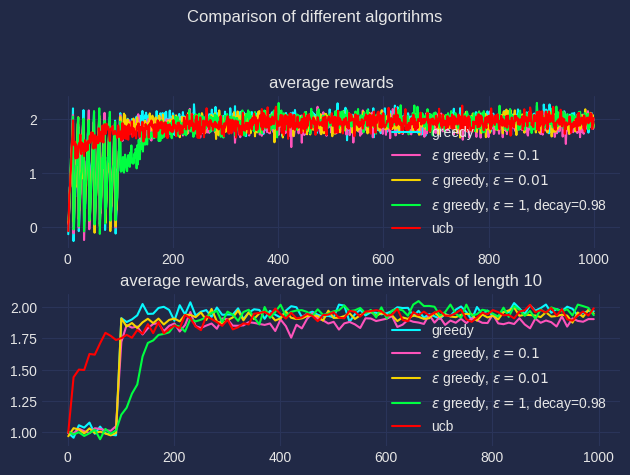

In [4]:
rewards = [0]*5
visits = [0]*5
regrets = [0]*5


for i in range(runs):
    methods = [
               e_greedy(bandits, 0, 1),
               e_greedy(bandits, 0.1, 1),
               e_greedy(bandits, 1, 0.98),
               UCB(bandits),
               e_greedy(bandits, 0.01, 1)
              ]
    for i in range(5):
        temp = methods[i].run(N)
        rewards[i] += temp[0]
        regrets[i] += temp[1]
        visits[i] += methods[i].visits
    
for i in range(5):
    regrets[i]/=runs
    rewards[i]/=runs
    visits[i]/=runs

fig, ax = plt.subplots(2, 1)
ax[0].plot(np.arange(1, N+1), rewards[0], label='greedy')
ax[0].plot(np.arange(1, N+1), rewards[1], label='$\epsilon$ greedy, $\epsilon=0.1$')
ax[0].plot(np.arange(1, N+1), rewards[4], label='$\epsilon$ greedy, $\epsilon=0.01$')
ax[0].plot(np.arange(1, N+1), rewards[2], label='$\epsilon$ greedy, $\epsilon=1$, decay=0.98')
ax[0].plot(np.arange(1, N+1), rewards[3], label='ucb')
ax[0].set_title('average rewards')
ax[0].legend()
ax[1].set_title('average rewards, averaged on time intervals of length 10')
ax[1].plot(np.arange(1, N+1, 10), [np.mean(rewards[0][10*i:10*i+10]) for i in range(100)],
           label='greedy')
ax[1].plot(np.arange(1, N+1, 10), [np.mean(rewards[1][10*i:10*i+10]) for i in range(100)],
           label='$\epsilon$ greedy, $\epsilon=0.1$')
ax[1].plot(np.arange(1, N+1, 10), [np.mean(rewards[4][10*i:10*i+10]) for i in range(100)],
           label='$\epsilon$ greedy, $\epsilon=0.01$')           
ax[1].plot(np.arange(1, N+1, 10), [np.mean(rewards[2][10*i:10*i+10]) for i in range(100)], 
           label='$\epsilon$ greedy, $\epsilon=1$, decay=0.98')
ax[1].plot(np.arange(1, N+1, 10), [np.mean(rewards[3][10*i:10*i+10]) for i in range(100)],
           label='ucb')
ax[1].legend()
fig.tight_layout()
fig.suptitle("Comparison of different algortihms")
plt.subplots_adjust(top=0.8)
plt.show()

# Part-D

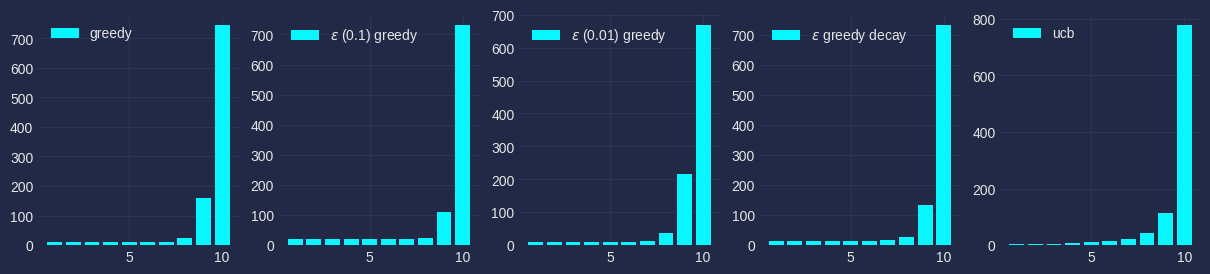

In [5]:
fig, ax = plt.subplots(1, 5 , figsize=(15, 3))
ax[0].bar(np.arange(1,11), visits[0], label= 'greedy')
ax[1].bar(np.arange(1,11), visits[1], label='$\epsilon$ (0.1) greedy')
ax[2].bar(np.arange(1,11), visits[4], label='$\epsilon$ (0.01) greedy')
ax[3].bar(np.arange(1,11), visits[2], label='$\epsilon$ greedy decay')
ax[4].bar(np.arange(1,11), visits[3], label= 'ucb')
for i in range(5):
        ax[i].legend()
plt.show()

# Part-E

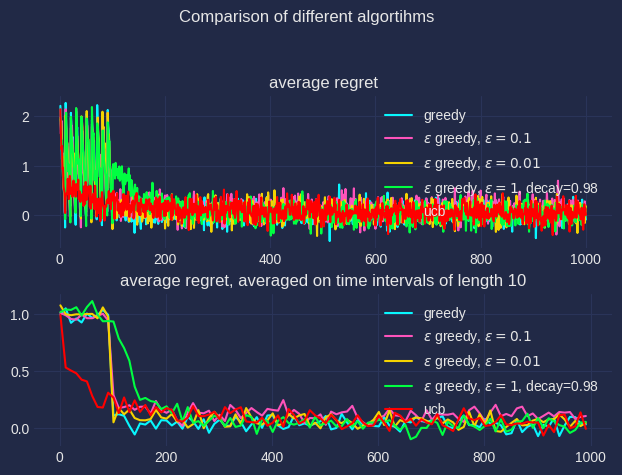

In [6]:
fig, ax = plt.subplots(2, 1)
ax[0].plot(np.arange(1, N+1), regrets[0], label='greedy')
ax[0].plot(np.arange(1, N+1), regrets[1], label='$\epsilon$ greedy, $\epsilon=0.1$')
ax[0].plot(np.arange(1, N+1), regrets[4], label='$\epsilon$ greedy, $\epsilon=0.01$')
ax[0].plot(np.arange(1, N+1), regrets[2], label='$\epsilon$ greedy, $\epsilon=1$, decay=0.98')
ax[0].plot(np.arange(1, N+1), regrets[3], label='ucb')
ax[0].set_title('average regret')
ax[0].legend()
ax[1].set_title('average regret, averaged on time intervals of length 10')
ax[1].plot(np.arange(1, N+1, 10), [np.mean(regrets[0][10*i:10*i+10]) for i in range(100)],
           label='greedy')
ax[1].plot(np.arange(1, N+1, 10), [np.mean(regrets[1][10*i:10*i+10]) for i in range(100)],
           label='$\epsilon$ greedy, $\epsilon=0.1$')
ax[1].plot(np.arange(1, N+1, 10), [np.mean(regrets[4][10*i:10*i+10]) for i in range(100)],
           label='$\epsilon$ greedy, $\epsilon=0.01$')
ax[1].plot(np.arange(1, N+1, 10), [np.mean(regrets[2][10*i:10*i+10]) for i in range(100)], 
           label='$\epsilon$ greedy, $\epsilon=1$, decay=0.98')
ax[1].plot(np.arange(1, N+1, 10), [np.mean(regrets[3][10*i:10*i+10]) for i in range(100)],
           label='ucb')
ax[1].legend()
fig.tight_layout()
fig.suptitle("Comparison of different algortihms")
plt.subplots_adjust(top=0.8)
plt.show()

In [7]:
print(f'Regret of greedy: {regrets[0].sum()}')
print(f'Regret of $\epsilon$ (0.1) greedy: {regrets[1].sum()}')
print(f'Regret of $\epsilon$ (0.01) greedy: {regrets[4].sum()}')
print(f'Regret of $\epsilon$ greedy with decay: {regrets[2].sum()}')
print(f'Regret of UCB: {regrets[3].sum()}')

Regret of greedy: 137.7923101664275
Regret of $\epsilon$ (0.1) greedy: 215.91211908414795
Regret of $\epsilon$ (0.01) greedy: 165.2884018511169
Regret of $\epsilon$ greedy with decay: 184.61022583966235
Regret of UCB: 121.90053394430966


# Part-F
The UCB algorithm is the best as it chooses the best arm more often as compared to other algorithms. The regret is also much smaller for UCB. As we see in the next part the results are better for UCB even when the best two arms have reward distribution means close to each other.

# Part-G

In [8]:
K = 10
means = np.linspace(0, 2, 10)
means[-2] = means[-1]-0.05
bandits = Bandits(K, means)
N = 1000
runs = 100

print(f'means: {means}')

means: [0.         0.22222222 0.44444444 0.66666667 0.88888889 1.11111111
 1.33333333 1.55555556 1.95       2.        ]


The best arm and second best arm reward distribution means differ by 0.05

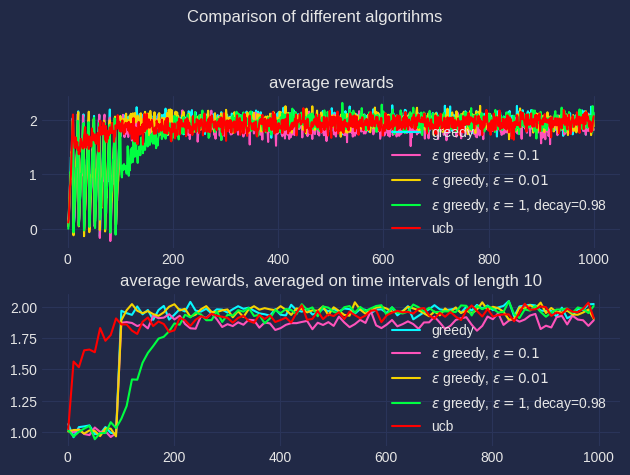

In [9]:
rewards = [0]*5
visits = [0]*5
regrets = [0]*5


for i in range(runs):
    methods = [
               e_greedy(bandits, 0, 1),
               e_greedy(bandits, 0.1, 1),
               e_greedy(bandits, 1, 0.98),
               UCB(bandits),
               e_greedy(bandits, 0.01, 1)
              ]
    for i in range(5):
        temp = methods[i].run(N)
        rewards[i] += temp[0]
        regrets[i] += temp[1]
        visits[i] += methods[i].visits
    
for i in range(5):
    regrets[i]/=runs
    rewards[i]/=runs
    visits[i]/=runs

fig, ax = plt.subplots(2, 1)
ax[0].plot(np.arange(1, N+1), rewards[0], label='greedy')
ax[0].plot(np.arange(1, N+1), rewards[1], label='$\epsilon$ greedy, $\epsilon=0.1$')
ax[0].plot(np.arange(1, N+1), rewards[4], label='$\epsilon$ greedy, $\epsilon=0.01$')
ax[0].plot(np.arange(1, N+1), rewards[2], label='$\epsilon$ greedy, $\epsilon=1$, decay=0.98')
ax[0].plot(np.arange(1, N+1), rewards[3], label='ucb')
ax[0].set_title('average rewards')
ax[0].legend()
ax[1].set_title('average rewards, averaged on time intervals of length 10')
ax[1].plot(np.arange(1, N+1, 10), [np.mean(rewards[0][10*i:10*i+10]) for i in range(100)],
           label='greedy')
ax[1].plot(np.arange(1, N+1, 10), [np.mean(rewards[1][10*i:10*i+10]) for i in range(100)],
           label='$\epsilon$ greedy, $\epsilon=0.1$')
ax[1].plot(np.arange(1, N+1, 10), [np.mean(rewards[4][10*i:10*i+10]) for i in range(100)],
           label='$\epsilon$ greedy, $\epsilon=0.01$')           
ax[1].plot(np.arange(1, N+1, 10), [np.mean(rewards[2][10*i:10*i+10]) for i in range(100)], 
           label='$\epsilon$ greedy, $\epsilon=1$, decay=0.98')
ax[1].plot(np.arange(1, N+1, 10), [np.mean(rewards[3][10*i:10*i+10]) for i in range(100)],
           label='ucb')
ax[1].legend()
fig.tight_layout()
fig.suptitle("Comparison of different algortihms")
plt.subplots_adjust(top=0.8)
plt.show()

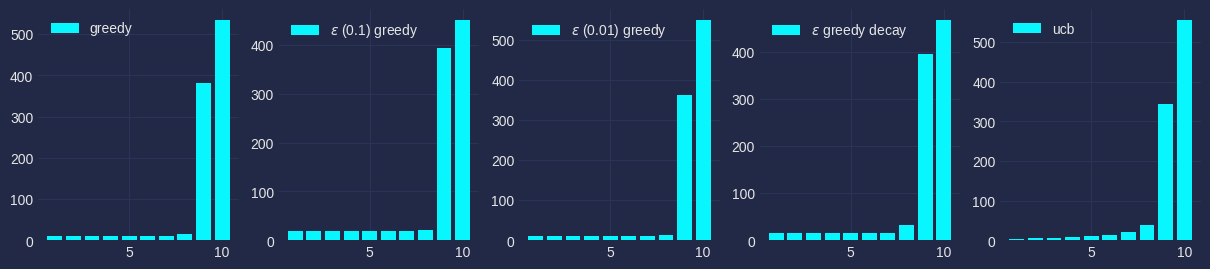

In [10]:
fig, ax = plt.subplots(1, 5 , figsize=(15, 3))
ax[0].bar(np.arange(1,11), visits[0], label= 'greedy')
ax[1].bar(np.arange(1,11), visits[1], label='$\epsilon$ (0.1) greedy')
ax[2].bar(np.arange(1,11), visits[4], label='$\epsilon$ (0.01) greedy')
ax[3].bar(np.arange(1,11), visits[2], label='$\epsilon$ greedy decay')
ax[4].bar(np.arange(1,11), visits[3], label= 'ucb')
for i in range(5):
        ax[i].legend()
plt.show()

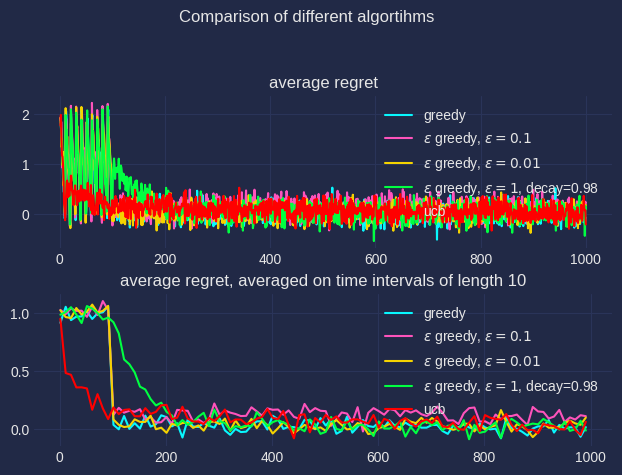

In [11]:
fig, ax = plt.subplots(2, 1)
ax[0].plot(np.arange(1, N+1), regrets[0], label='greedy')
ax[0].plot(np.arange(1, N+1), regrets[1], label='$\epsilon$ greedy, $\epsilon=0.1$')
ax[0].plot(np.arange(1, N+1), regrets[4], label='$\epsilon$ greedy, $\epsilon=0.01$')
ax[0].plot(np.arange(1, N+1), regrets[2], label='$\epsilon$ greedy, $\epsilon=1$, decay=0.98')
ax[0].plot(np.arange(1, N+1), regrets[3], label='ucb')
ax[0].set_title('average regret')
ax[0].legend()
ax[1].set_title('average regret, averaged on time intervals of length 10')
ax[1].plot(np.arange(1, N+1, 10), [np.mean(regrets[0][10*i:10*i+10]) for i in range(100)],
           label='greedy')
ax[1].plot(np.arange(1, N+1, 10), [np.mean(regrets[1][10*i:10*i+10]) for i in range(100)],
           label='$\epsilon$ greedy, $\epsilon=0.1$')
ax[1].plot(np.arange(1, N+1, 10), [np.mean(regrets[4][10*i:10*i+10]) for i in range(100)],
           label='$\epsilon$ greedy, $\epsilon=0.01$')
ax[1].plot(np.arange(1, N+1, 10), [np.mean(regrets[2][10*i:10*i+10]) for i in range(100)], 
           label='$\epsilon$ greedy, $\epsilon=1$, decay=0.98')
ax[1].plot(np.arange(1, N+1, 10), [np.mean(regrets[3][10*i:10*i+10]) for i in range(100)],
           label='ucb')
ax[1].legend()
fig.tight_layout()
fig.suptitle("Comparison of different algortihms")
plt.subplots_adjust(top=0.8)
plt.show()

In [12]:
print(f'Regret of greedy: {regrets[0].sum()}')
print(f'Regret of $\epsilon$ (0.1) greedy: {regrets[1].sum()}')
print(f'Regret of $\epsilon$ (0.01) greedy: {regrets[4].sum()}')
print(f'Regret of $\epsilon$ greedy with decay: {regrets[2].sum()}')
print(f'Regret of UCB: {regrets[3].sum()}')

Regret of greedy: 121.1327136475477
Regret of $\epsilon$ (0.1) greedy: 212.96549683515542
Regret of $\epsilon$ (0.01) greedy: 128.76971906128773
Regret of $\epsilon$ greedy with decay: 173.90671247685765
Regret of UCB: 102.90255272138283


The regret achieved in UCB is again lower than other algorithms